In [167]:
import numpy as np
# import units as u
import numpy as np
from scipy.ndimage import gaussian_filter
import pandas as pd


import rasterio
from rasterio.plot import show_hist, show
import geopandas as gpd
import rasterstats
from shapely.geometry import shape

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt

from icecream import ic



### state boundaries

In [168]:
states_path = "data/states/nga_admbnda_adm1_osgof_20161215.shp"
states = gpd.read_file(states_path)

<AxesSubplot: >

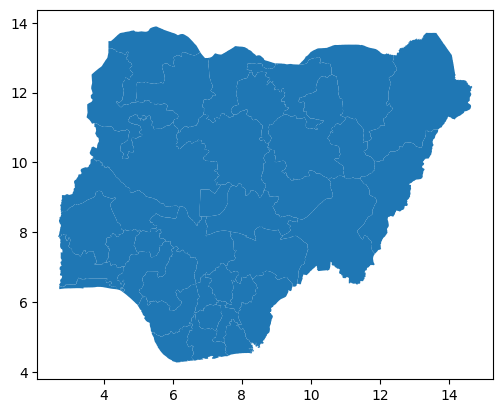

In [169]:
states.plot()

In [170]:
states["geometry"].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [171]:
states_m = states.to_crs('epsg:32632')

In [172]:
states_m.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [173]:
state_areas = pd.DataFrame(states_m.apply(lambda x: (x.admin1Name, shape(x["geometry"]).area ), axis=1).to_list(), columns=["state", "area (m2)"])
state_areas

,state,area (m2)
0,Abia,4.858882e+09
1,Adamawa,3.792499e+10
2,Akwa Ibom,6.736774e+09
3,Anambra,4.807933e+09
4,Bauchi,4.849640e+10
5,Bayelsa,9.546396e+09
6,Benue,3.146223e+10
7,Borno,7.247472e+10
8,Cross River,2.093993e+10
9,Delta,1.711300e+10


In [174]:
state_areas["area (m2)"].sum() # 9.23768e+11

911689252976.8823

In [175]:
state_areas["area (m2)"].sum()/ 1e6 # 923,768 km 2

911689.2529768823

### wind data 

In [176]:
wind_data_path = "data/Nigeria_MeanWindSpeed/NGA_wind-speed_100m.tif"
wind_data = rasterio.open(wind_data_path)
wind_data_array = wind_data.read()[0]

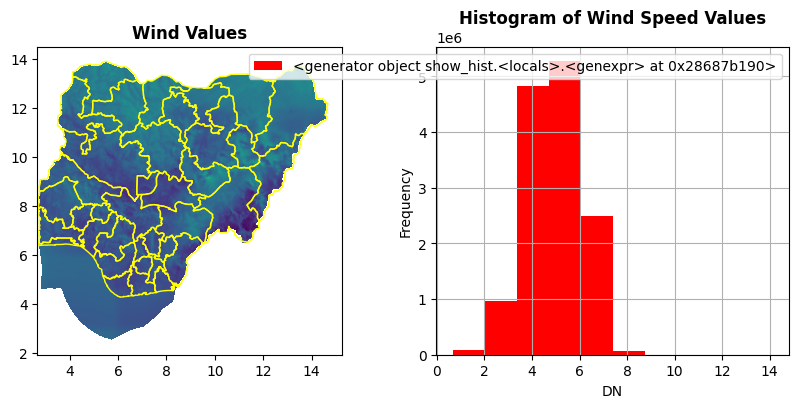

In [177]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 4))
show(wind_data, ax=ax1, title="Wind Values")
states.plot(ax=ax1, facecolor="None", edgecolor="yellow")
show_hist(wind_data, title="Histogram of Wind Speed Values", ax=ax2)
plt.show()

In [178]:
wind_data.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 4793,
 'height': 4788,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.002500000000000124, 0.0, 2.66657268219373,
        0.0, -0.002500000000000124, 13.890768747733846)}

In [179]:
wind_data.read_crs()

CRS.from_epsg(4326)

In [180]:
affine = wind_data.transform
affine
# width of pixel, row rotation, x-coord of upper left pixel
# column rotation, height of pixel, y-coord of upper left pixel

Affine(0.002500000000000124, 0.0, 2.66657268219373,
       0.0, -0.002500000000000124, 13.890768747733846)

In [181]:
# calculate zonal statistics
average_wind = rasterstats.zonal_stats(states, wind_data_array, affine=affine, stats = ["mean"], geojson_out=True)

In [182]:
state_wind_average = {}
for item in average_wind:
    state_wind_average[item["properties"]["admin1Name"]] = item["properties"]["mean"]



In [183]:
state_wind_average = []
for item in average_wind:
    state_wind_average.append((item["properties"]["admin1Name"],
    item["properties"]["mean"]))

In [184]:
pd.DataFrame(state_wind_average, columns=["state", "value"])

,state,value
0,Abia,4.174551
1,Adamawa,4.721773
2,Akwa Ibom,3.769858
3,Anambra,3.886427
4,Bauchi,4.950543
5,Bayelsa,3.705482
6,Benue,4.832989
7,Borno,5.843542
8,Cross River,3.788994
9,Delta,4.051140


### dni data 

In [186]:
dni_path = "data/Nigeria_AvgDailyTotals_GlobalSolarAtlas_GEOTIFF/DNI.tif"
dni_data = rasterio.open(dni_path)
dni_data_array = dataset.read()[0]

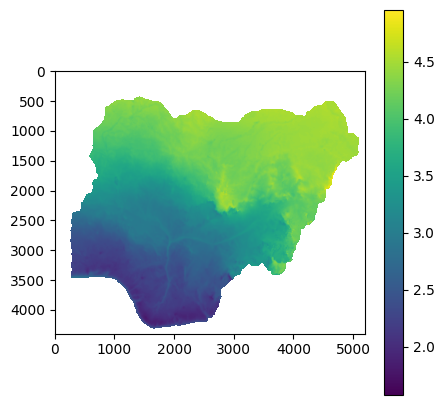

In [192]:
fig, ax1 = plt.subplots(figsize=(5, 5))
# ax1 = fig.add_subplot()
im = plt.imshow(dni_data_array)
fig.colorbar(im, ax=ax1)

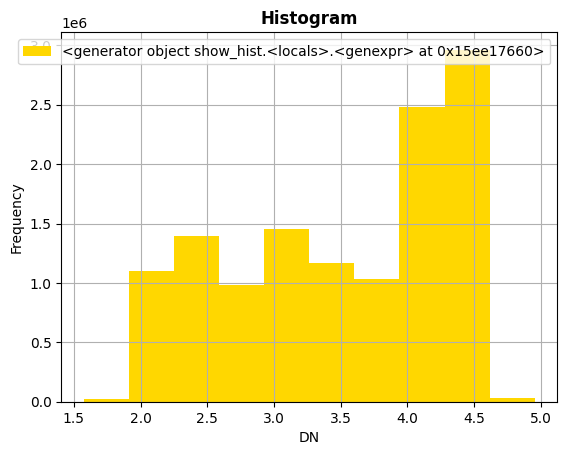

In [18]:
show_hist(dataset_vals[0])

### trying to segment

In [21]:
dataset_vals0 = dataset_vals[0]
seg1 = (dataset_vals0 < 2.75)
seg2 = (dataset_vals0 > 2.75) & (dataset_vals0 < 4.0 )
seg3 = (dataset_vals0 > 4.0 )

In [24]:
all_segments = np.zeros((dataset_vals0.shape[0], dataset_vals0.shape[1], 3))

In [25]:
all_segments[seg1] = (1, 0, 0 )
all_segments[seg2] = (0, 1, 0 )
all_segments[seg3] = (0, 0, 1 )

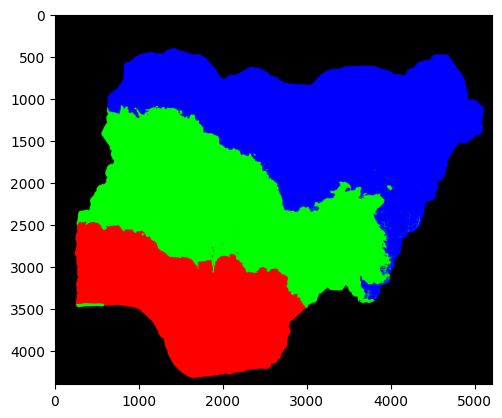

In [26]:
plt.imshow(all_segments)

In [19]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 5200,
 'height': 4400,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0025, 0.0, 2.0,
        0.0, -0.0025, 15.0)}

try to segment image based on DNI 

In [33]:
smooth_dataset0 = gaussian_filter(dataset_vals0, sigma=50)

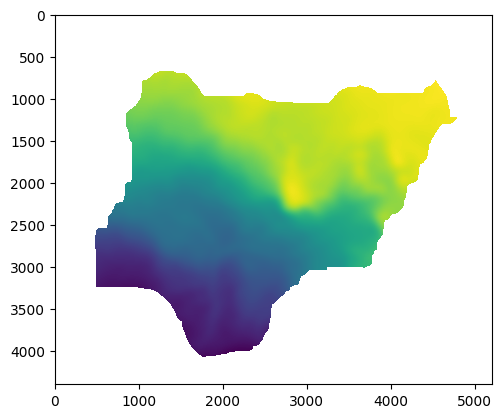

In [34]:
plt.imshow(smooth_dataset0)

### first pass at evaluating solar resource

Assume some made up information about horizantal solar flux of irradiance

In [32]:
N = 8
rng = np.random.default_rng(seed=1)

F_cur_spatial = np.round(rng.random((N,N)),1)

# need spatial information for wind and temperature as well
T_a_spatial = np.round(rng.uniform(low=20, high=32, size=(N,N)),2)
w_spatial = np.round(rng.rayleigh(scale=5, size=(N,N)),2)

F_cur_spatial # W/m^2 current solar flux normal to the panel 

array([[0.5, 1. , 0.1, 0.9, 0.3, 0.4, 0.8, 0.4],
       [0.5, 0. , 0.8, 0.5, 0.3, 0.8, 0.3, 0.5],
       [0.1, 0.4, 0.2, 0.3, 0.8, 0.3, 0.5, 1. ],
       [1. , 0.7, 0.5, 0.3, 0.2, 1. , 0.5, 0.1],
       [0.6, 0.8, 0.6, 0.9, 0. , 0.5, 0.5, 0.1],
       [0.6, 0.9, 0.6, 0.3, 0.8, 0.5, 0.5, 0.8],
       [0.1, 0.8, 0.7, 0.8, 0.2, 0.8, 0.2, 0.1],
       [0.9, 0.9, 0.9, 0.5, 0.3, 0. , 0.6, 0.7]])

In [18]:
fig = go.Figure()
fig = go.Figure(data=go.Heatmap(
                    z=F_cur_spatial))
fig.show()
# unsure what spatial dimension of heat flux data is but this could be something similiar potentially ...

In [42]:
wind_data_vals0 = wind_data_vals[0]

In [43]:
wind_data_vals0.shape

(4788, 4793)

In [44]:
dataset_vals0.shape

(4400, 5200)

In [55]:
def calculate_power_panel(F_cur, T_a, w):
    """
    F_cur = _ # W/m^2 current solar flux normal to the panel 
    T_a = _ # K / ºC, air temperature the panel is exposed to 
    w = _ # m/s, wind speed panel is exposed to 

    => all of these are 2x2 arrays with spatial information 
    
    """

    # values that change based on design! 
    D_f = 0.864 # derating factor, product of correction factors for additional processes affecting solar output, Table 5.2 
    E_panel = 0.18 # solar panel efficiency obtained under standard test conditions -- Ex 5.2
    A_panel = 1.5 # m^2, surface area of the pane -- Ex 5.2
    
    # 5.9, cell temperature, empirical so units do not eqate 
    T_c = T_a + 0.32 * (F_cur/(8.91 + 2*w))

    b_ref = 0.0025 # / K, temperature coefficient 
    T_th = 55 # K, threshold temeprature 
    T_ref = 298.15 # K, reference temperature 
    # 5.8, correction for cell temperature 
    C_temp = 1 - b_ref * np.maximum( np.minimum(T_c - T_ref, T_th ), 0 )

    # 5.7 actual AC power output from a solar panel at a given time 
    # P_ac = p_mpp_stc * C_temp * D_f / F_1000
    P_ac = F_cur * A_panel * E_panel * C_temp * D_f # units?? # should i be considering the rating of the panel as well? 

    return P_ac
    

In [58]:
single_panel_potential = calculate_power_panel(F_cur_spatial, T_a_spatial, w_spatial)

# this gives the P_ac of a single cell in a given area 

In [ ]:
# when this cell is in series / parallel, the maximum power point changes, Section 5.1.6 

# panels in series 
    # => open circuit voltage = sum ( open circuit voltage each panel), and v_mp increases
    # => short circuit current = same as initial panel
    # power => v_mp * i_mp 

In [57]:
# what is the spacing of the data in the gis file? => 250 m resolution 
# 5.1.5 => PV panel => 72, 96, or 128 pre-wired cells in series 
# one panel produces 0.5 - 0.7 V or energy potential 

# want to maximize voltage..

# hoq does p_ac change when the panel is in series / in parallel? am i supposed to know information about the voltage / current through this? here ill assume that the derating factor tales care of this, and just multiply by the size of the farm...

A_spacing = 250 #m2
A_panel = 1.5 # m2
n_panels = A_spacing / A_panel 
n_panels

166.66666666666666

In [59]:
# max possible power out for each region ...
farm_potenial = single_panel_potential * n_panels
farm_potenial # think this is instantaneous power? 

# need to get to energy and then compare energy production to energy needs ...


array([[19.44 , 38.88 ,  3.888, 34.992, 11.664, 15.552, 31.104, 15.552],
       [19.44 ,  0.   , 31.104, 19.44 , 11.664, 31.104, 11.664, 19.44 ],
       [ 3.888, 15.552,  7.776, 11.664, 31.104, 11.664, 19.44 , 38.88 ],
       [38.88 , 27.216, 19.44 , 11.664,  7.776, 38.88 , 19.44 ,  3.888],
       [23.328, 31.104, 23.328, 34.992,  0.   , 19.44 , 19.44 ,  3.888],
       [23.328, 34.992, 23.328, 11.664, 31.104, 19.44 , 19.44 , 31.104],
       [ 3.888, 31.104, 27.216, 31.104,  7.776, 31.104,  7.776,  3.888],
       [34.992, 34.992, 34.992, 19.44 , 11.664,  0.   , 23.328, 27.216]])